<a href="https://colab.research.google.com/github/JoeJiang3936/NLP/blob/master/Bert_finetuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [32]:
!pip install transformers

In [0]:
import tensorflow as tf

In [34]:
# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [0]:
import torch

In [36]:
if torch.cuda.is_available():
  device = torch.device("cuda")
  print("There are %d GPU(s) available." % torch.cuda.device_count())
  print("We will use GPU:", torch.cuda.get_device_name(0))
else:
  print('There are no GPU available, using the CPU instead.')
  device = torch.device("cpu")

There are 1 GPU(s) available.
We will use GPU: Tesla P100-PCIE-16GB


In [37]:
#CoLA dataset, a small dataset containing 10,000 sentences. The task: whether a sentence is grammatically correct or not. 
!pip install wget
import wget
import os
print("Downloading the CoLA dataset ...")

url = 'https://nyu-mll.github.io/CoLA/cola_public_1.1.zip'
wget.download(url, './cola_public_1.1.zip')

'./cola_public_1.1 (1).zip'

In [0]:
if not os.path.exists('./cola_public/'):
  !unzip cola_public_1.1.zip

In [39]:
import pandas as pd
df = pd.read_csv("./cola_public/raw/in_domain_train.tsv", delimiter = '\t', header = None, names = ["sentence_source", "label", "label_notes", "sentence"])
print("The number of sentences :", df.shape[0])
df.head(10)

The number of sentences : 8551


,sentence_source,label,label_notes,sentence
0,gj04,1,NaN,"Our friends won't buy this analysis, let alone..."
1,gj04,1,NaN,One more pseudo generalization and I'm giving up.
2,gj04,1,NaN,One more pseudo generalization or I'm giving up.
3,gj04,1,NaN,"The more we study verbs, the crazier they get."
4,gj04,1,NaN,Day by day the facts are getting murkier.
5,gj04,1,NaN,I'll fix you a drink.
6,gj04,1,NaN,Fred watered the plants flat.
7,gj04,1,NaN,Bill coughed his way out of the restaurant.
8,gj04,1,NaN,We're dancing the night away.
9,gj04,1,NaN,Herman hammered the metal flat.


In [40]:
df.loc[df.label == 0].sample(10)[['sentence','label']]


,sentence,label
5465,I have six of them more.,0
2105,I lent Tony the book halfway.,0
591,the bottle drained the liquid free.,0
3188,She always clad herself in black.,0
3477,the box contains little tool.,0
496,They tried all to like John.,0
7365,It mattered with a telescope.,0
1823,"It started to rain after Jackie and me, we had...",0
3926,Sketch by his students appeared in the magazine.,0
6751,"Because did Marianne love Willoughby, she refu...",0


In [41]:
sentences = df.sentence.values
labels = df.label.values
print(sentences[:10], labels[:10]) 

["Our friends won't buy this analysis, let alone the next one we propose."
 "One more pseudo generalization and I'm giving up."
 "One more pseudo generalization or I'm giving up."
 'The more we study verbs, the crazier they get.'
 'Day by day the facts are getting murkier.' "I'll fix you a drink."
 'Fred watered the plants flat.'
 'Bill coughed his way out of the restaurant.'
 "We're dancing the night away." 'Herman hammered the metal flat.'] [1 1 1 1 1 1 1 1 1 1]


In [42]:
from transformers import BertTokenizer
print('Load BERT tokenizer ...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case = True)

Load BERT tokenizer ...


In [43]:
print("Original sentence: ", sentences[0])
print('Tokenized sentence: ', tokenizer.tokenize(sentences[0]))
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0])))

Original sentence:  Our friends won't buy this analysis, let alone the next one we propose.
Tokenized sentence:  ['our', 'friends', 'won', "'", 't', 'buy', 'this', 'analysis', ',', 'let', 'alone', 'the', 'next', 'one', 'we', 'propose', '.']
Token IDs:  [2256, 2814, 2180, 1005, 1056, 4965, 2023, 4106, 1010, 2292, 2894, 1996, 2279, 2028, 2057, 16599, 1012]


In [44]:
#convert into IDs
input_ids = []
for sentence in sentences:
  encoded_sentence = tokenizer.encode(sentence, add_special_tokens=True)
  input_ids.append(encoded_sentence)

print('Original sentence: ', sentences[1])
print('Encoded sentence IDs: ', input_ids[1])


Original sentence:  One more pseudo generalization and I'm giving up.
Encoded sentence IDs:  [101, 2028, 2062, 18404, 2236, 3989, 1998, 1045, 1005, 1049, 3228, 2039, 1012, 102]


In [45]:
#padding and truncating
max_lens = max(len(sentence) for sentence in input_ids)
print('The longest sentence in the dataset: ', max_lens)

from keras.preprocessing.sequence import pad_sequences
MAX_LEN  = 48
print('padding all sentences to MAX_LEN = %d...'%MAX_LEN)

input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype='long', value=0, truncating='post', padding='post')
input_ids[1]

The longest sentence in the dataset:  47
padding all sentences to MAX_LEN = 48...


array([  101,  2028,  2062, 18404,  2236,  3989,  1998,  1045,  1005,
        1049,  3228,  2039,  1012,   102,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0])

In [46]:
#add attention masks
attention_masks = []
for sentence in input_ids:
  mask = [int(id>0) for id in sentence]
  attention_masks.append(mask)
attention_masks[0]

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [47]:
from sklearn.model_selection import train_test_split
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, random_state = 2018, test_size = 0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, labels, random_state = 2018, test_size = 0.1)
print('training dataset size: ', len(train_inputs))
print('validation dataset size: ', len(validation_inputs))
print(len(train_masks), len(train_masks[0]))
print(len(train_inputs), len(train_inputs[0]))

training dataset size:  7695
validation dataset size:  856
7695 48
7695 48


In [48]:
#converting to Pytorch datatypes
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)

train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)

train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)
print(train_inputs.shape)
print(train_masks.shape)
print(validation_inputs.shape)
print(validation_masks.shape)

torch.Size([7695, 48])
torch.Size([7695, 48])
torch.Size([856, 48])
torch.Size([856, 48])


In [0]:
# use dataloader to train the model in batches, it is more memory-efficient than a for loop

from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
batch_size = 32
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler = train_sampler, batch_size = batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = RandomSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler = validation_sampler, batch_size = batch_size)

In [50]:
#fine tuning the bert model
from transformers import BertForSequenceClassification
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels = 2)
model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [51]:
#exploring the weights of the bert model
params = list(model.named_parameters())
print('The Bert base model has {:} different named parameters. \n'.format(len(params)))
print('Embedding layer')
for parameter in params[0:5]:
  print("{:<55} {:>12}".format(parameter[0], str(tuple(parameter[1].size()))))
print('\nFirst Transformer')
for parameter in params[5:21]:
  print("{:<55} {:>12}".format(parameter[0], str(tuple(parameter[1].size()))))
print('\nOutput layer')
for parameter in params[-4:]:
  print("{:<55} {:>12}".format(parameter[0], str(tuple(parameter[1].size()))))

The Bert base model has 201 different named parameters. 

Embedding layer
bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

First Transformer
bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (768,)
bert.encod

In [0]:
#define the optimizer
from transformers import AdamW
optimizer = AdamW(model.parameters(), lr = 2e-5, eps = 1e-8, weight_decay = 0.001)

In [0]:
from transformers import get_linear_schedule_with_warmup
epochs = 12
total_steps = len(train_dataloader)*epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0, num_training_steps = total_steps)

In [0]:
#classification accuracy function
def accuracy(preds, labels):
  pred_flat = np.argmax(preds, axis=1).flatten()
  labels_flat = labels.flatten()
  return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [0]:
import time
import datetime


def format_time(elapsed):
  elapsed_rounded = int(round(elapsed))
  return str(datetime.timedelta(seconds = elapsed_rounded)) 


In [56]:
import random
import numpy as np

random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

loss_values = []

model.zero_grad()

for epoch in range(epochs):
  print('training at epoch: ', epoch +1)
  t0 = time.time()

  total_loss = 0

  model.train()

  for step, batch in enumerate(train_dataloader):
    if step%40 == 0 and not step == 0:
      elapsed = format_time(time.time() - t0)

      print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))
    model.train()

    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(device)

    outputs = model(b_input_ids, token_type_ids = None, attention_mask = b_input_mask, labels = b_labels)

    loss = outputs[0]
    total_loss += loss

    loss.backward()

    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    optimizer.step()

    scheduler.step()

    model.zero_grad()
  
  avg_train_loss = total_loss/len(train_dataloader)

  loss_values.append(avg_train_loss)

  print("  Average training loss: {0:.2f}".format(avg_train_loss))
  print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))

  print('validating...')

  t0 = time.time()

  model.eval()

  eval_loss, eval_accuracy = 0, 0 
  nb_eval_steps, nb_eval_examples = 0, 0 

  for batch in validation_dataloader:
    batch = tuple(t.to(device) for t in batch)

  b_input_ids, b_input_mask, b_labels = batch    
        
  with torch.no_grad():
    outputs = model(b_input_ids, token_type_ids = None, attention_mask=b_input_mask)

  logits = outputs[0]

  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()

  tmp_eval_accuracy = accuracy(logits, label_ids)
  eval_accuracy += tmp_eval_accuracy

  nb_eval_steps += 1

  print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
  print("  Validation took: {:}".format(format_time(time.time() - t0)))

training at epoch:  1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.


  Batch    40  of    241.    Elapsed: 0:00:08.
  Batch    80  of    241.    Elapsed: 0:00:15.
  Batch   120  of    241.    Elapsed: 0:00:23.
  Batch   160  of    241.    Elapsed: 0:00:31.
  Batch   200  of    241.    Elapsed: 0:00:38.
  Batch   240  of    241.    Elapsed: 0:00:46.
  Average training loss: 0.49
  Training epcoh took: 0:00:46
validating...
  Accuracy: 0.75
  Validation took: 0:00:00
training at epoch:  2
  Batch    40  of    241.    Elapsed: 0:00:08.
  Batch    80  of    241.    Elapsed: 0:00:15.
  Batch   120  of    241.    Elapsed: 0:00:23.
  Batch   160  of    241.    Elapsed: 0:00:30.
  Batch   200  of    241.    Elapsed: 0:00:38.
  Batch   240  of    241.    Elapsed: 0:00:46.
  Average training loss: 0.31
  Training epcoh took: 0:00:46
validating...
  Accuracy: 0.92
  Validation took: 0:00:00
training at epoch:  3
  Batch    40  of    241.    Elapsed: 0:00:08.
  Batch    80  of    241.    Elapsed: 0:00:15.
  Batch   120  of    241.    Elapsed: 0:00:23.
  Batch   160

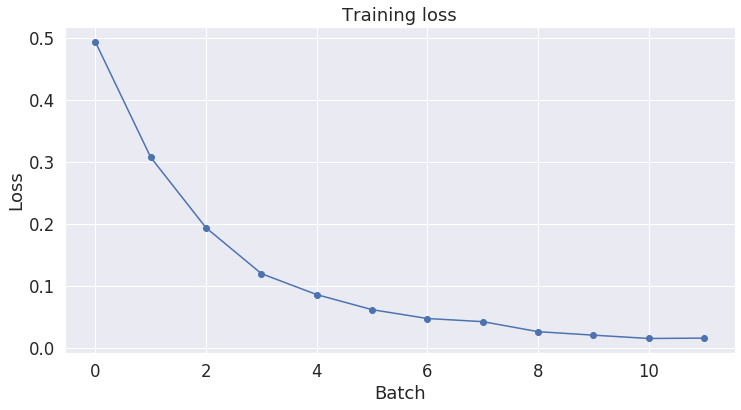

In [57]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o')

# Label the plot.
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")

plt.show()

In [58]:
import pandas as pd

# Load the test dataset into a pandas dataframe.
df = pd.read_csv("./cola_public/raw/out_of_domain_dev.tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])

# Report the number of sentences.
print('Number of test sentences: {:,}\n'.format(df.shape[0]))

# Create sentence and label lists
sentences = df.sentence.values
labels = df.label.values

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []

# For every sentence...
for sent in sentences:
    # `encode` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    encoded_sent = tokenizer.encode(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                   )
    
    input_ids.append(encoded_sent)

# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, 
                          dtype="long", truncating="post", padding="post")

# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask) 

# Convert to tensors.
prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(labels)

# Set the batch size.  
batch_size = 32  

# Create the DataLoader.
prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

Number of test sentences: 516



In [59]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(prediction_inputs)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 516 test sentences...
    DONE.


In [60]:
print('Positive samples: %d of %d (%.2f%%)' % (df.label.sum(), len(df.label), (df.label.sum() / len(df.label) * 100.0)))

Positive samples: 354 of 516 (68.60%)


In [61]:
from sklearn.metrics import matthews_corrcoef

matthews_set = []

# Evaluate each test batch using Matthew's correlation coefficient
print('Calculating Matthews Corr. Coef. for each batch...')

# For each input batch...
for i in range(len(true_labels)):
  
  # The predictions for this batch are a 2-column ndarray (one column for "0" 
  # and one column for "1"). Pick the label with the highest value and turn this
  # in to a list of 0s and 1s.
  pred_labels_i = np.argmax(predictions[i], axis=1).flatten()
  
  # Calculate and store the coef for this batch.  
  matthews = matthews_corrcoef(true_labels[i], pred_labels_i)                
  matthews_set.append(matthews)

Calculating Matthews Corr. Coef. for each batch...


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


In [62]:
# Combine the predictions for each batch into a single list of 0s and 1s.
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = [item for sublist in true_labels for item in sublist]

# Calculate the MCC
mcc = matthews_corrcoef(flat_true_labels, flat_predictions)

print('MCC: %.3f' % mcc)

MCC: 0.566
